# Resonator + Kerr nonlinearities + Paramp simulation 

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *

In [2]:
from IPython.display import HTML

In [3]:
from matplotlib import animation

In [4]:
from qutip import *

## Functions for plotting

We start by defining some function for visualizing the dynamics. We'll use these further down in the notebook. 

In [5]:
def plot_expect_with_variance(N, op_list, op_title, states):
    """
    Plot the expectation value of an operator (list of operators)
    with an envelope that describes the operators variance.
    """
    
    fig, axes = plt.subplots(1, len(op_list), figsize=(14,3))

    for idx, op in enumerate(op_list):
        
        e_op = expect(op, states)
        v_op = variance(op, states)

        axes[idx].fill_between(tlist, e_op - sqrt(v_op), e_op + sqrt(v_op), color="red", alpha=0.5);
        axes[idx].plot(tlist, e_op)
        axes[idx].set_xlabel('Time')
        axes[idx].set_title(op_title[idx])
        axes[idx].set_xlim(0, max(tlist))

    return fig, axes

In [6]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))

    if isket(rho):
        rho = ket2dm(rho)
    
    xvec = linspace(-7.5,7.5,200)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)

    return fig, ax

In [ ]:
def plot_wigner_2d_3d(psi):
    #fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))
    fig = plt.figure(figsize=(17, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    plot_wigner(psi, fig=fig, ax=ax);

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    plot_wigner(psi, fig=fig, ax=ax);
    
    plt.close(fig)
    return fig

In [7]:
def plot_fock_distribution_vs_time(tlist, states, fig=None, ax=None):
    
    Z = zeros((len(tlist), states[0].shape[0]))
    
    for state_idx, state in enumerate(states):
        Z[state_idx,:] = real(ket2dm(state).diag())
        
    if fig is None or axes is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,6))

    Y, X = meshgrid(tlist, range(states[0].shape[0]))
    p = ax.pcolor(X, Y, Z.T, norm=mpl.colors.Normalize(0, 0.5), cmap=mpl.cm.get_cmap('rainbow'), edgecolors='k')
    ax.set_xlabel(r'$N$', fontsize=16)
    ax.set_ylabel(r'$t$', fontsize=16)    
    
    cb = fig.colorbar(p)
    cb.set_label('Probability')
    
    return fig, ax

In [8]:
#We need this for codec and visualization of time dynamics

from base64 import b64encode

def display_embedded_video(filename):
    video = open(filename, "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
    return HTML(video_tag)

## Introduction

The effective Hamiltonian:

$\displaystyle H = \hbar\Delta a^{\dagger}a +  \frac{\hbar}{2} K (a^{\dagger2}a^2) - \frac{\hbar}{2}p (a^2+a^{\dagger2})$

where $\Delta$ is the detuning of the oscillator eigenfrequency from the half of pump frequency, $K$ is related to the third-order nonlinear suseptibility and $p$ is proportional to the product of the amplitude of the parametric pump field and the second-order susceptibility.

In this notebook we'll see how to setup the model in QuTiP and look at some interesting properties of the states that evolve according to this Hamiltonian.

## Parameters

In [9]:
N = 15

# operators: the annihilation operator of the field
a = destroy(N)

# and we'll also need the following operators in calculation of
# expectation values when visualizing the dynamics 
n = num(N)
x = a + a.dag()
p = -1j * (a - a.dag())

In [89]:
delta = 0.1 * 2 * pi            # oscillator - pump frequency/2 detuning
K = 0.2 * 2 * pi                # Kerr-nonlinearity      
pump =  20 * delta               # Pumping of the system  

tlist = linspace(0, 1, 101)   # time

In [90]:
# the Kerr + Paramp Hamiltonian
H = delta * a.dag() * a + 0.5 * K * a.dag() * a.dag() * a * a - 0.5 * pump * (a.dag() * a.dag() + a * a)
#H = 0.5 * K * a.dag() * a.dag() * a * a - 0.5 * pump * (a.dag() * a.dag() + a * a)

## Coherent state

Let's look at how the $\textbf{coherent state}$ evolves under the influence of the Kerr + Paramp Hamiltonian.

In [102]:
# we start with a coherent state with alpha=2.0
psi0 = coherent(N, 2)

In [103]:
# and evolve the state under the influence of the hamiltonian. 
# by passing an empty list as expecation value operators argument, 
# we get the full state of the system in result.states
result = mesolve(H, psi0, tlist, [], [])

In [119]:
result.states[0]

Quantum object: dims = [[15], [1]], shape = (15, 1), type = ket
Qobj data =
[[0.13533528]
 [0.27067057]
 [0.38278599]
 [0.44200318]
 [0.4420032 ]
 [0.3953396 ]
 [0.32279381]
 [0.24400758]
 [0.17254547]
 [0.11500965]
 [0.07280249]
 [0.04372088]
 [0.02570884]
 [0.01315459]
 [0.00944713]]

First, let's look at how the $\textbf{expecation values}$ and $\textbf{variances}$ of the photon number operator $n$ and the $x$ and $p$ quadratures evolve in time:

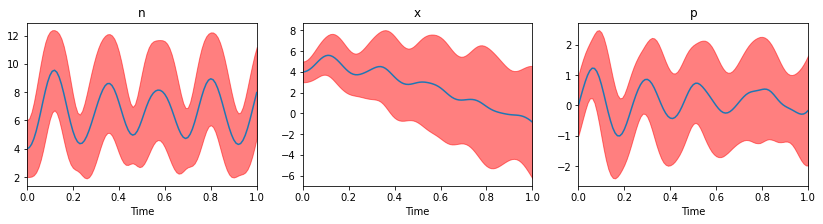

In [106]:
plot_expect_with_variance(N, [n, x, p], [r'n', r'x', r'p'], result.states);

Note that the average photon number $\langle n \rangle$ and the corresponding variance is $\textbf{not}$ constant (the Fock state distribution is not preserved (?) ). From the plots above we can also see that during the evolution the variance in $x$ and $p$ change as a function of time. 

To verify that the photon distribution indeed is $\textbf{time-dependent}$, we can plot the fock distribution as a function of time:

<ipython-input-7-4955d354d98e>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolor(X, Y, Z.T, norm=mpl.colors.Normalize(0, 0.5), cmap=mpl.cm.get_cmap('rainbow'), edgecolors='k')


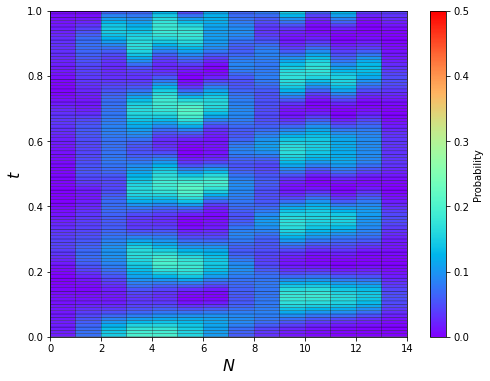

In [109]:
plot_fock_distribution_vs_time(tlist, result.states);

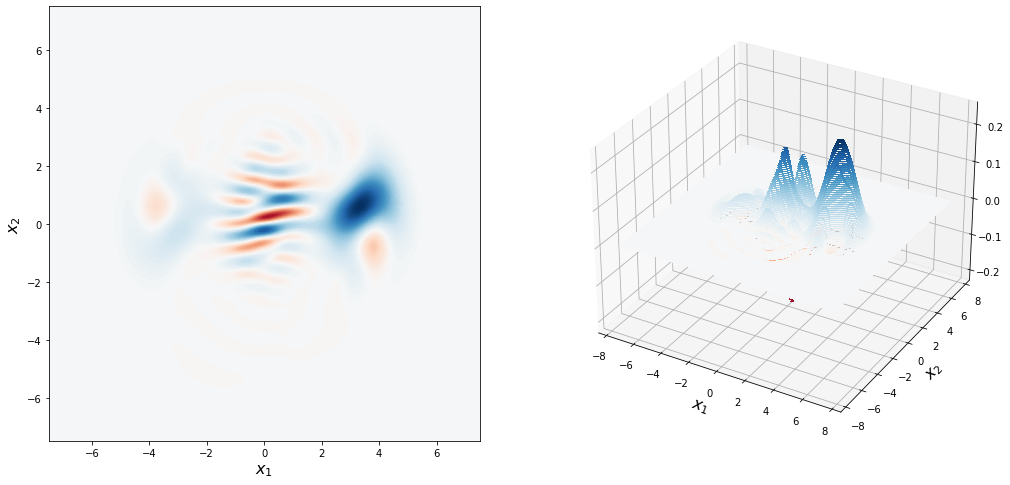

In [111]:
plot_wigner_2d_3d(result.states[50])

So the fock state distribution is not constant, and let's now see how the $\textbf{Wigner function}$ of the state evolves in time. 

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

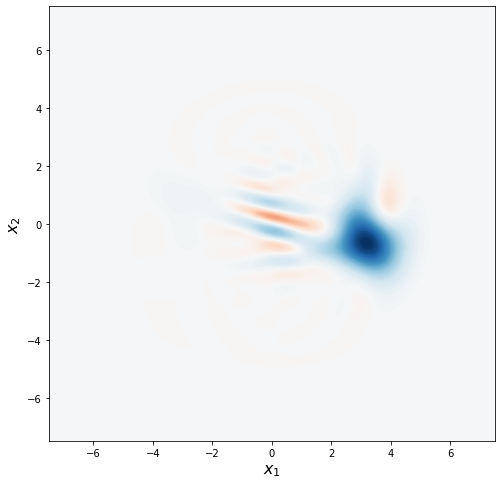

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_wigner(result.states[20], fig=fig, ax=ax)

To best illustrate the dynamics of the Winger function we make a short movie that show the Wigner function from time $t=0$ to the the final time of the evolution.

In [113]:
plt.rcParams['animation.ffmpeg_path'] ='C:\\ffmpeg\\bin\\ffmpeg.exe'  # path to codec location

In [114]:
mywriter = animation.FFMpegWriter()

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

def update(n): 
    plot_wigner(result.states[n], fig=fig, ax=ax)

anim = animation.FuncAnimation(fig, update, frames=len(result.states))

anim.save('C:/notebooks/animations/kerr+paramp-coherent-state_2_detuning.mp4', writer=mywriter)

plt.close(fig)

In [116]:
#display_embedded_video("C:/notebooks/animations/kerr+paramp-coherent-state_giant_pump.mp4")
#display_embedded_video("C:/notebooks/animations/kerr+paramp-coherent-state_giant_pump_2.mp4")
#display_embedded_video("C:/notebooks/animations/kerr+paramp-coherent-state_4.mp4")
#display_embedded_video("C:/notebooks/animations/kerr+paramp-coherent-state_0_detuning.mp4")
display_embedded_video("C:/notebooks/animations/kerr+paramp-coherent-state_2_detuning.mp4")

The dynamics is periodic, and we evolved the state for exactly one period, so that the final state is (more or less) equal ($\textbf{no}$) to the initial state (due to the influence of pumping term).

In between there is interesting stuff going on. For example, after half the period the state ends up in something that look very much like a $\textbf{cat-state}$ superposition of coherent states!

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

def update(n): 
    plot_wigner(result.states[n], fig=fig, ax=ax)

anim = animation.FuncAnimation(fig, update, frames=int(len(result.states)/2+1))

#anim.save('animation-kerr-coherent-state-half-period.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('C:/notebooks/animations/kerr+paramp-coherent-state-half-period.mp4', writer=mywriter)

plt.close(fig)

In [37]:
display_embedded_video('C:/notebooks/animations/kerr+paramp-coherent-state-half-period.mp4')

Now let's check how stable state of the system evolve from the vacuum state with increasing of p/$\Delta$ ratio.

In [32]:
psi0 = coherent(N, 0)

p_to_Delta_ratio = linspace(0, 5.0, 101)   

delta = 1 * 2 * pi            
K = delta                

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

def update(n): 
    pump =  p_to_Delta_ratio[n]*delta  
    H = delta * a.dag() * a + 0.5 * K * a.dag() * a.dag() * a * a - 0.5 * pump * (a.dag() * a.dag() + a * a)
    result = mesolve(H, psi0, tlist, [], [])
    plot_wigner(result.states[50], fig=fig, ax=ax)

anim = animation.FuncAnimation(fig, update, frames=len(result.states))

#anim.save('animation-kerr-coherent-state-half-period.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('C:/notebooks/animations/oscil+kerr+paramp_vacuum_state_power_sweep.mp4', writer=mywriter)

plt.close(fig)

In [34]:
display_embedded_video('C:/notebooks/animations/oscil+kerr+paramp_vacuum_state_power_sweep.mp4')

The cat state

$\psi = \frac{1}{\sqrt{2}}\left(e^{i\pi/4}|-i\alpha\rangle + e^{-i\pi/4}|i\alpha\rangle\right)$

In [86]:
N=15
#psi = (exp(1j*pi/4) * coherent(N, -1j*2) + exp(-1j*pi/4) * coherent(N, 1j*2)).unit()
psi = (exp(1j*pi/4) * coherent(N, -1j*2) + exp(-1j*pi/4) * coherent(N, 1j*2)).unit()

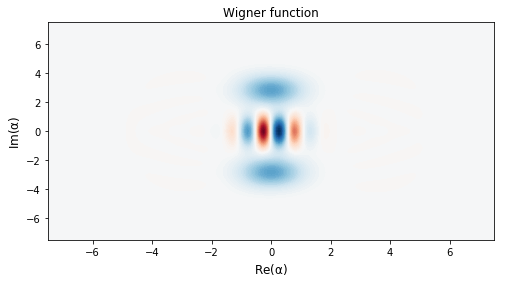

In [87]:
plot_wigner(psi);

### Software versions

In [35]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.6.2
Numpy,1.20.1
SciPy,1.6.2
matplotlib,3.3.4
Cython,0.29.23
Number of CPUs,8
BLAS Info,INTEL MKL
IPython,7.22.0
Python,"3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]"
OS,nt [win32]
